In [ ]:
# ============================================================
# SENTIMENT ANALYSIS with BERT-base - OPTIMIZED VERSION
# ============================================================

import os
import pandas as pd
import torch
import re
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ============================================================
# SETUP
# ============================================================
os.environ["WANDB_DISABLED"] = "true"

# ============================================================
# LOAD & ENHANCED CLEAN DATA
# ============================================================
df = pd.read_csv("./drive/MyDrive/Dataset/amazon_3class_balanced.csv")

# Enhanced cleaning for BERT
def enhanced_clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'[^\w\s]', ' ', text)  # Better punctuation handling
    text = re.sub(r'\s+', ' ', text)
    text = text.lower().strip()  # BERT works better with lowercase
    return text

print("🧹 Enhanced cleaning for BERT...")
df['review_body'] = df['review_body'].apply(enhanced_clean_text)
df = df[df['review_body'].str.len() > 25]  # More strict filtering
print(f"After enhanced cleaning: {len(df)} samples")

# Encode labels
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["sentiment"].map(label2id)

# DATASET: 80K per class (240K total)
df = (
    df.groupby("sentiment", group_keys=False)
    .apply(lambda x: x.sample(80000, random_state=42))
    .reset_index(drop=True)
)

print("Training with:", len(df), "samples")

# Split into train/test sets (80/20)
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Convert to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# ============================================================
# TOKENIZER (BERT with longer sequences)
# ============================================================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["review_body"],
        padding="max_length",
        truncation=True,
        max_length=128  # Increased for BERT
    )

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=1000)
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=1000)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# ============================================================
# MODEL (BERT-base)
# ============================================================
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

# ============================================================
# TRAINING CONFIGURATION (OPTIMIZED FOR BERT)
# ============================================================
training_args = TrainingArguments(
    output_dir="./results",  # New directory
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,  # Optimized for BERT
    per_device_eval_batch_size=16,   # Consistent batch sizes
    learning_rate=2e-5,              # Standard BERT learning rate
    num_train_epochs=6,
    weight_decay=0.01,
    fp16=True,
    warmup_steps=1000,
    lr_scheduler_type="cosine",
    logging_steps=200,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
)

# ============================================================
# METRICS FUNCTION
# ============================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# ============================================================
# TRAINER
# ============================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# ============================================================
# TRAINING
# ============================================================
print("\n==================== BERT TRAINING STARTED ====================")
print("🚀 Using BERT-base with 240K samples")
trainer.train()
print("==================== TRAINING COMPLETED ====================\n")

# ============================================================
# EVALUATION
# ============================================================
metrics = trainer.evaluate()
print("==================== EVALUATION METRICS ====================")
print(metrics)

# ============================================================
# SAVE MODEL
# ============================================================
model.save_pretrained("./amazon_sentiment_bert")
tokenizer.save_pretrained("./amazon_sentiment_bert")

# ============================================================
# SAMPLE PREDICTIONS
# ============================================================
test_reviews = [
    "This product is absolutely amazing!",
    "It was okay, nothing special.",
    "Terrible quality and waste of money.",
]

model = model.cpu()
inputs = tokenizer(test_reviews, padding=True, truncation=True, return_tensors="pt")
outputs = model(**inputs)
preds = torch.argmax(outputs.logits, dim=1)

print("\n" + "=" * 50)
print("PREDICTION RESULTS:")
print("=" * 50)
for review, pred in zip(test_reviews, preds):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {id2label[pred.item()]}\n")

print("🎯 BERT training completed!")

🧹 Enhanced cleaning for BERT...
After enhanced cleaning: 1480998 samples


/tmp/ipython-input-3914705352.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(80000, random_state=42))


Training with: 240000 samples
Training samples: 192000
Test samples: 48000


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/192000 [00:00<?, ? examples/s]

Map:   0%|          | 0/48000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3914705352.py:136: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



==================== BERT TRAINING STARTED ====================
🚀 Using BERT-base with 240K samples


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.558400,0.549262,0.769125,0.769139,0.769370,0.769125
2,0.464800,0.570560,0.769542,0.769605,0.772166,0.769542
3,0.350900,0.650678,0.763750,0.762779,0.763438,0.763750
4,0.237400,0.853242,0.760958,0.760240,0.759682,0.760958


==================== TRAINING COMPLETED ====================



==================== EVALUATION METRICS ====================
{'eval_loss': 0.5705597400665283, 'eval_accuracy': 0.7695416666666667, 'eval_f1': 0.7696046099575985, 'eval_precision': 0.7721656622072163, 'eval_recall': 0.7695416666666667, 'eval_runtime': 93.2291, 'eval_samples_per_second': 514.861, 'eval_steps_per_second': 32.179, 'epoch': 4.0}

PREDICTION RESULTS:
Review: This product is absolutely amazing!
Predicted Sentiment: positive

Review: It was okay, nothing special.
Predicted Sentiment: neutral

Review: Terrible quality and waste of money.
Predicted Sentiment: negative

🎯 BERT training completed!


📥 Loading model and tokenizer...


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

🧠 Generating predictions...

🎯 Overall Accuracy: 77.90%


<Figure size 600x500 with 0 Axes>

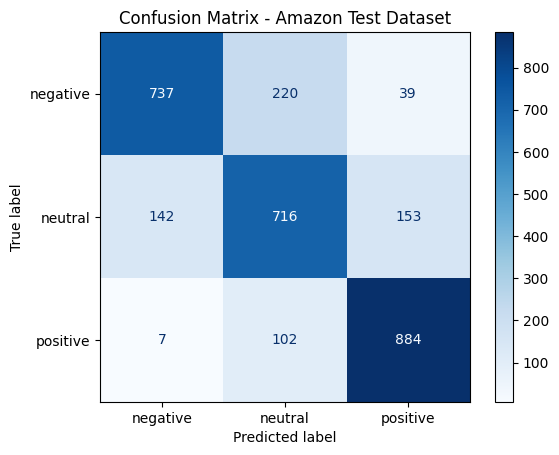


📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.74      0.78       996
     neutral       0.69      0.71      0.70      1011
    positive       0.82      0.89      0.85       993

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



In [4]:
# ============================================================
# CONFUSION MATRIX + ACCURACY FOR TRAINED BERT MODEL
# ============================================================

import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from torch.utils.data import DataLoader

# ------------------------------------------------------------
# Load Saved Model and Tokenizer
# ------------------------------------------------------------
model_path = "./amazon_sentiment_bert"

print("📥 Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()  # inference mode

# ------------------------------------------------------------
# Load Amazon Test Data
# ------------------------------------------------------------
df = pd.read_csv("./drive/MyDrive/Dataset/amazon_3class_balanced.csv")

def enhanced_clean_text(text):
    import re
    if pd.isna(text):
        return ""
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()

df['review_body'] = df['review_body'].apply(enhanced_clean_text)
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["sentiment"].map(label2id)

# Use smaller test sample for faster evaluation
df = df.sample(3000, random_state=42).reset_index(drop=True)

# ------------------------------------------------------------
# Tokenize Test Data
# ------------------------------------------------------------
def tokenize(batch):
    return tokenizer(
        batch["review_body"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

dataset = Dataset.from_pandas(df)
dataset = dataset.map(tokenize, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# ------------------------------------------------------------
# Generate Predictions
# ------------------------------------------------------------
loader = DataLoader(dataset, batch_size=32)
all_preds, all_labels = [], []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("🧠 Generating predictions...")
for batch in loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# ------------------------------------------------------------
# Metrics, Confusion Matrix, and Accuracy
# ------------------------------------------------------------
accuracy = accuracy_score(all_labels, all_preds)
print(f"\n🎯 Overall Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["negative", "neutral", "positive"]
)

plt.figure(figsize=(6,5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Amazon Test Dataset")
plt.show()

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))

Device set to use cuda:0


Loading trained sentiment model...
✅ Model directory found
Files in model directory: ['tokenizer_config.json', 'model.safetensors', 'config.json', 'tokenizer.json', 'special_tokens_map.json', 'vocab.txt', '.ipynb_checkpoints']
📥 Loading tokenizer and model...
🔧 Creating pipeline...
✅ Model loaded successfully!

🎯 TESTING WITH UNSEEN YELP DATASET
📥 Loading Yelp reviews...
✅ Loaded 500 Yelp reviews

Yelp sentiment distribution:
true_sentiment
positive    353
negative     79
neutral      68
Name: count, dtype: int64

🧪 Testing model on Yelp reviews...
Processed 50/500 reviews...
Processed 100/500 reviews...
Processed 150/500 reviews...
Processed 200/500 reviews...
Processed 250/500 reviews...
Processed 300/500 reviews...
Processed 350/500 reviews...
Processed 400/500 reviews...
Processed 450/500 reviews...
Processed 500/500 reviews...

📊 YELP DATASET TEST RESULTS:
✅ Accuracy: 0.880
✅ Precision: 0.892
✅ Recall: 0.880
✅ F1-score: 0.884

📈 CLASSIFICATION REPORT:
              precision    re

<Figure size 600x500 with 0 Axes>

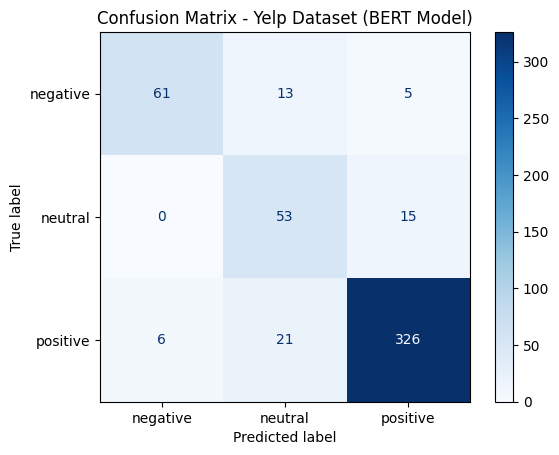


📝 SAMPLE PREDICTIONS:
Review: If you decide to eat here, just be aware it is going to take about 2 h...
True: neutral, Predicted: neutral (0.746)

Review: I've taken a lot of spin classes over the years, and nothing compares ...
True: positive, Predicted: positive (0.984)

Review: Family diner. Had the buffet. Eclectic assortment: a large chicken leg...
True: neutral, Predicted: positive (0.901)

Review: Wow!  Yummy, different,  delicious.   Our favorite is the lamb curry a...
True: positive, Predicted: positive (0.985)

Review: Cute interior and owner (?) gave us tour of upcoming patio/rooftop are...
True: positive, Predicted: positive (0.648)

🎯 Yelp dataset evaluation completed successfully!


In [3]:
# ============================================================
# LOAD MODEL + YELP TESTING + CONFUSION MATRIX
# ============================================================

print("Loading trained sentiment model...")

import os
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# ------------------------------------------------------------
# LOAD TRAINED MODEL
# ------------------------------------------------------------
model_path = "./amazon_sentiment_bert"
if os.path.exists(model_path):
    print("✅ Model directory found")
    print("Files in model directory:", os.listdir(model_path))
else:
    print("❌ Model directory not found at:", model_path)

try:
    print("📥 Loading tokenizer and model...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    print("🔧 Creating pipeline...")
    sentiment_model = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1
    )
    print("✅ Model loaded successfully!")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Trying alternative loading method...")
    sentiment_model = pipeline(
        "text-classification",
        model=model_path,
        device=0 if torch.cuda.is_available() else -1
    )
    print("✅ Model loaded via direct pipeline!")

# ------------------------------------------------------------
# LOAD YELP DATASET
# ------------------------------------------------------------
print("\n🎯 TESTING WITH UNSEEN YELP DATASET")

def load_yelp_reviews_safe(sample_size=500):
    reviews = []
    count = 0
    try:
        with open("./drive/MyDrive/Dataset/yelp_academic_dataset_review.json", 'r', encoding='utf-8') as f:
            for line in f:
                if count >= sample_size:
                    break
                try:
                    review_data = json.loads(line)
                    text = review_data.get('text', '').strip()
                    stars = review_data.get('stars', 0)
                    if text and 1 <= stars <= 5:
                        reviews.append({
                            'text': text[:500],
                            'stars': stars
                        })
                        count += 1
                except Exception:
                    continue
    except FileNotFoundError:
        print("❌ Yelp file not found!")
        return pd.DataFrame()
    return pd.DataFrame(reviews)

print("📥 Loading Yelp reviews...")
yelp_df = load_yelp_reviews_safe(500)
print(f"✅ Loaded {len(yelp_df)} Yelp reviews")

# ------------------------------------------------------------
# MAP STAR RATINGS TO SENTIMENT CLASSES
# ------------------------------------------------------------
def map_yelp_sentiment(stars):
    if stars <= 2: return "negative"
    elif stars == 3: return "neutral"
    else: return "positive"

yelp_df['true_sentiment'] = yelp_df['stars'].apply(map_yelp_sentiment)
print("\nYelp sentiment distribution:")
print(yelp_df['true_sentiment'].value_counts())

# ------------------------------------------------------------
# RUN MODEL ON YELP REVIEWS
# ------------------------------------------------------------
print("\n🧪 Testing model on Yelp reviews...")
print("=" * 60)

results = []
for idx, row in yelp_df.iterrows():
    try:
        pred = sentiment_model(row['text'])[0]
        results.append({
            "text": row["text"],
            "true": row["true_sentiment"],
            "pred": pred["label"],
            "confidence": pred["score"]
        })
        if (idx + 1) % 50 == 0:
            print(f"Processed {idx + 1}/{len(yelp_df)} reviews...")
    except Exception as e:
        print(f"❌ Error on review {idx}: {e}")
        continue

# ------------------------------------------------------------
# CALCULATE METRICS
# ------------------------------------------------------------
true_labels = [r["true"] for r in results]
pred_labels = [r["pred"] for r in results]

acc = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")

print("\n📊 YELP DATASET TEST RESULTS:")
print(f"✅ Accuracy: {acc:.3f}")
print(f"✅ Precision: {precision:.3f}")
print(f"✅ Recall: {recall:.3f}")
print(f"✅ F1-score: {f1:.3f}")

# ------------------------------------------------------------
# CLASSIFICATION REPORT & CONFUSION MATRIX
# ------------------------------------------------------------
print("\n📈 CLASSIFICATION REPORT:")
print(classification_report(true_labels, pred_labels, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(true_labels, pred_labels, labels=["negative", "neutral", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Yelp Dataset (BERT Model)")
plt.show()

# ------------------------------------------------------------
# SAMPLE PREDICTIONS
# ------------------------------------------------------------
print("\n📝 SAMPLE PREDICTIONS:")
print("=" * 50)
for i in range(5):
    print(f"Review: {results[i]['text'][:70]}...")
    print(f"True: {results[i]['true']}, Predicted: {results[i]['pred']} ({results[i]['confidence']:.3f})\n")

print("🎯 Yelp dataset evaluation completed successfully!")